# Validator Rewards in Practice
In the [previous article](https://pintail.xyz/posts/beacon-chain-validator-rewards/) we looked at the rewards and penalties validators receive for participating in the beacon chain's consensus process and assembled a model to estimate expected net rewards, based on network participation rate and validator uptime. This time we're going to look at data from mainnet to see how it compares. We'll be using [Jim McDonald](https://twitter.com/jgm)'s invaluable [chaind](https://github.com/wealdtech/chaind) tool to index the beacon chain to do this. We'll be focusing on data the first 32,000 epochs (around 4½ months) so that for now we can disregard the impact of the [block production incident](https://medium.com/prysmatic-labs/eth2-mainnet-incident-retrospective-f0338814340c), which occurred in late April 2021.

# Modelling Average Net Reward

Let's start by looking at aggregate data from the network. By aggregating all this data across more than 120,000 validators, we will get a view of the *average* rewards/penalties received by validators. This allows us to pick up where we left off last time, since all the values calculated by our model in the previous article were *expected* (i.e. average) values, so we should get a good sense of how well the model fits the observed network performance. After that we can go a bit deeper into the individual reward/penalty componenets, and individual validators. This can give us an idea precisely which types of issue are leading to performance which falls short of the ideal.

Recall that our model for expected net rewards was given by:
$$
R = 3BPU - 3B(1-U) + \frac{7}{8}BPU\frac{\ln(P)}{P-1} + \frac{1}{8}BPU
$$
However, since we're modelling the whole network in aggregate, we will assume that each individual validator's uptime $U$ is equal to the overall network participation rate $P$ which gives us:
$$
R = 3BP^2 - 3B(1-P) + \frac{7}{8}BP^2\frac{\ln(P)}{P-1} + \frac{1}{8}BP^2
$$

Our model therefore has only two parameters — the participation rate $P$, and the the base reward $B$, which is in turn a function of the the total active stake. For simplicity's sake, let's assume that the participation rate $P$ is constant for the period being considered, and use the average observed value from the network. For each epoch, this is given by the sum of the *attesting balance* — the combined effective balance of all validators whose attestations were included — divided by the total *active balance* — the combined effective balance of all active validators.

In [32]:
# imports, constants, db connection
import time
from datetime import datetime

import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import math

FAR_FUTURE_EPOCH = 2**64 - 1 # as defined in spec

# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [6]:
# find average participation rate

cursor.execute("SELECT f_active_balance, f_attesting_balance FROM t_epoch_summaries "
               "WHERE f_epoch < 32000 ORDER BY f_epoch")
active_balance, attesting_balance = list(zip(*cursor.fetchall()))

p_rate = [attesting_balance[i] / active_balance[i] for i in range(len(active_balance))]
average_p_rate = sum(p_rate)/len(p_rate)

print(f"average participation rate: {100*average_p_rate:.1f}%")

average participation rate: 99.0%


As calculated above, the average participation rate across the first 32,000 epochs is 99%. Armed with this figure, we can model the expected reward, based on the amount of Ether staked by active validators each epoch.

# Actual Average Rewards

We also need to calculate what the actual average reward was. We can do this by looking at how the balances of the active validators changed, as recorded by chaind. There are a few adjustments we need to make to the aggregate figures to accurately reflect mainnet rewards and penalties:

1. We exclude eth1 deposits erroneously made by some users to active validators;
2. We exclude slashed validators, since slashing penalties are relatively large, but are only incurred when multiple instances of the same validator are run simultaneously or for provably malicious actions;
3. We exclude validators who slash others, since the large rewards received by these validators also distort the overall picture of rewards.

What proportion validators are we excluding from our analysis by removing the slashed and slashers? We can calculate a quick and dirty upper-bound on this figure by looking at the number of validators we are excluding from the set (the number of slashed validators plus the validators who did the slashing) and dividing by minimimum number of active validators — i.e. number of the genesis validators.

In [14]:
# calculate upper bound on percentage of excluded validators

cursor.execute("SELECT COUNT(*) FROM t_validators WHERE f_slashed")
n_to_remove = 2 * cursor.fetchone()[0]

print(f"number of slashed/slasher validators: {n_to_remove}")

cursor.execute("SELECT COUNT(*) FROM t_validators WHERE f_activation_epoch = 0")
n_genesis = cursor.fetchone()[0]

print(f"minimum number of active validators: {n_genesis}")
print(f"upper-bound percentage of validators excluded from average: {100 * n_to_remove / n_genesis:.1f}%")

number of slashed/slasher validators: 268
minimum number of active validators: 21063
upper-bound percentage of validators excluded from average: 1.3%


As the calculation above shows, at worst we are excluding 1.3% of the validator set from our analysis. We expect therefore that our calculations of average net reward will not be significantly affected. The [code used to calculate the average rewards](epoch_extras.py) and store the relevant data in the chaind database was run separately.

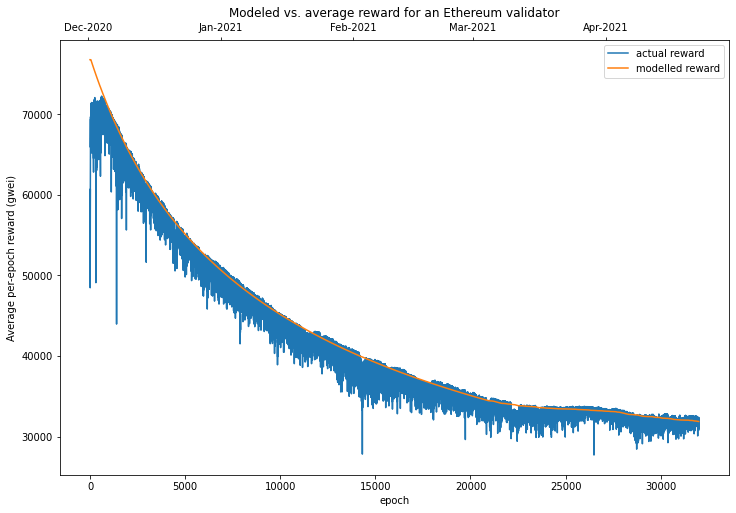

In [40]:
# calculate and plot modelled and average rewards

def base_reward(active_balance, effective_balance=int(32e9)):
    return effective_balance * 64 // math.isqrt(active_balance) // 4

cursor.execute("SELECT * FROM t_epoch_extras WHERE f_epoch < 32000 ORDER BY f_epoch")
_, aggregate_reward, aggregate_reward_nonslashed, active_balance_nonslashed = list(zip(*cursor.fetchall()))

average_reward_nonslashed = []
modelled_reward = []
for e in range(32000):
    # look at the average reward received by a supposed 32 ETH validator
    # (almost all validators have a 32 ETH effective balance)
    average_reward_nonslashed.append(32e9 * aggregate_reward_nonslashed[e] / active_balance_nonslashed[e])
    
    p = average_p_rate
    b = base_reward(active_balance[e])
    modelled_reward.append(3*b*p**2-3*b*(1-p)+(7/8)*b*p**2*math.log(p)/(p-1)+(1/8)*b*p**2)

rewards = pd.DataFrame({
    "average_reward_nonslashed": average_reward_nonslashed,
    "modelled_reward":modelled_reward
})

fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(range(32000), average_reward_nonslashed, label="actual reward")
ax1.plot(range(32000), modelled_reward, label="modelled reward")
ax1.legend()
ax2.plot([datetime(2020,12,1,12,0,23), datetime(2021,4,22,17,13,59)], [0,0], linestyle="None")

ax2.set_title('Modeled vs. average reward for an Ethereum validator')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Average per-epoch reward (gwei)')
ax2.xaxis.tick_top()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_visible(False);

As shown in the chart above, our simple model seems to be a fairly good fit for the data, but overall it seems to predict slightly higher rewards than were actually the case. Let's calculate just how much this premium was:

In [4]:
# calculate model premium

premium = [modelled_reward[i] / a - 1 for i, a in enumerate(average_reward_nonslashed)]
average_premium = sum(premium) / len(premium)

print(f"on average, the model predicted {100 * average_premium:.2}% "
      f"higher rewards than were observed in practice")

on average, the model predicted 1.7% higher rewards than were observed in practice


So, at a 1.7% overestimate for average rewards, our model captured the vast majority of the variability in average per-epoch rewards. The slight overestimate however seems to be fairly consistent across the dataset. Where does it come from?

# Deeper Into Beacon Chain Rewards

The model we developed in the previous article was based on a key assumption which allowed us to describe validator performance using a single number — participation rate. What this means is that for a given epoch, each validator was treated either as being "on" and performing perfectly, or "off" and failing to carry out any of its duties of attestation or block proposal. As we saw above, this model seems to describe the data reasonably well, but had a tendency to slightly over-estimate expected rewards.
The block proposer receives $\frac{1}{8}$ of a `base_reward` for including the attestation.

The reason for this is that it is possible for a validator to fulfill its attestation duties, but without receiving the full reward. To understand how this can happen, we need to look a little closer at what validators are actually rewarded *for*. As mentioned in the previous article, attestations can be rewarded with up to one `base_reward` for each of four things:
1. **Correct source vote**. An attestation contains a vote for the checkpoint block serving as the "source" for the CasperFFG finality overlay. In practice an attestation can only be included if the source vote is correct, so the source vote reward could equivalently be treated as an "inclusion reward".
2. **Correct target vote**. An vote for the checkpoint block serving as the "target" for the CapserFFG finality overlay.
3. **Correct head vote**. A vote for the current block at the head of the chain.
4. **Inclusion delay**. A final `base_reward` is split between the attester and block proposer. The attester receives a maximum of $\frac{7}{8}$ `base_reward`, scaled inversely by the number of slots of delay to inclusion. The block proposer receives $\frac{1}{8}$ `base_reward` for each attestation they include.

*NB for full details of the meaning and function of "source", "target" and "head" votes, see the [Gasper paper](https://arxiv.org/pdf/2003.03052.pdf).*

The proportion of validators receiving reward (1) is already described fully by the participation rate. If validators don't include the correct source vote, their attestations won't be included at all, and in effect this means the validator does not participate. Rewards (2) and (3) are slightly different — validators vote for the block that appears to them to be the 'correct' target or head block, but some validators may have an incomplete or delayed view of the blockchain, leading them to vote for a block which is different to the one ultimately finalised for that slot. In such cases, validators which voted for the 'correct' block receive a partial `base_reward`, scaled in proportion with the proportion of the active stake which voted the same way. Validators who vote for an 'incorrect' block will penalised one whole `base_reward`.

We've talked about the inclusion delay before — but our model assumed that 'online' validators would only have their attestations delayed if the earliest inclusion slot had no block. In practice, attestations may be delayed by other factors too — network latency could mean that the block proposer does not receive the attestation in time for inclusion into the earliest block, for example.

So, to understand the implications of this more detailed understanding of rewards and penalties, let's have a look in detail at the performance of a single validator. We'll start by focusing on validator 0.

In [47]:
cursor.execute("SELECT * FROM t_validator_epoch_summaries "
               "WHERE f_validator_index = 0 AND f_epoch BETWEEN 0 AND 31999 "
               "ORDER BY f_epoch")
validator_summary = cursor.fetchall()

proposer_duties = proposals_included = attestation_included = target_correct = head_correct = 0
inclusion_delay = [0] * 32
for epoch in range(32000):
    if validator_summary[epoch][2] > validator_summary[epoch][3]:
        print(f"{validator_summary[epoch][2]} proposal duties for epoch {epoch}, only {validator_summary[epoch][3]} included")
    proposer_duties += validator_summary[epoch][2]
    proposals_included += validator_summary[epoch][3]
    attestation_included += validator_summary[epoch][4]
    if validator_summary[epoch][5]:
        target_correct += 1
    if validator_summary[epoch][6]:
        head_correct += 1
    if validator_summary[epoch][7]:
        inclusion_delay[validator_summary[epoch][7]] += 1

print(f"proposer dutes: {proposer_duties}, proposals_included: {proposals_included} "
      f"({100*proposals_included/proposer_duties:.1f}%)")

1 proposal duties for epoch 0, only 0 included
proposer dutes: 14, proposals_included: 13 (92.9%)
